# Data

## Build Dataset

Papers with Code: https://paperswithcode.com/paper/detecting-inspiring-content-on-social-media

Link to GitHub: https://github.com/oanaignat/reddit_inspiring_posts

Link to dataset: https://github.com/OanaIgnat/reddit_inspiring_posts/blob/master/data_all_post_ids.csv

*   Inspiring/Not-Inspiring post-IDs were provided by the researchers.
*   However, none of the post content was provided. In order to rebuild the dataset, I used the Python Reddit API Wrapper to collect Post Titles and Post Content.

In [ ]:
@misc{ignat2021detecting,
    title={Detecting Inspiring Content on Social Media},
    author={Oana Ignat and Y-Lan Boureau and Jane A. Yu and Alon Halevy},
    year={2021},
    eprint={2109.02734},
    archivePrefix={arXiv},
    primaryClass={cs.CL}
}

import pandas as pd

ids = pd.read_csv('data_all_post_ids.csv')

In [ ]:
ids.head()

,inspiring,not inspiring
0,18ypya,5s6czm
1,8u3p2f,2q1xjz
2,194wmf,16ff5p
3,1h8ctp,18fto4
4,17pkxd,671m2n


In [ ]:
inspiring=ids['inspiring']
not_inspiring=ids['not inspiring']

In [ ]:
inspiring = pd.DataFrame(inspiring).assign(result = 1)
not_inspiring = pd.DataFrame(not_inspiring).assign(result = 0)

In [ ]:
inspiring = inspiring.rename(columns = {'inspiring':'id'})
not_inspiring = not_inspiring.rename(columns = {'not inspiring':'id'})

In [ ]:
df = inspiring.append(not_inspiring)

In [ ]:
df.head()

,id,result
0,18ypya,1
1,8u3p2f,1
2,194wmf,1
3,1h8ctp,1
4,17pkxd,1


### Test PRAW

In [ ]:
!pip install praw

In [ ]:
#Test Python Reddit API Wrapper

import praw

reddit = praw.Reddit(client_id='F77JkePeSXMBgL_u3m9CBQ',
                     client_secret='DgQrUlyRndRlDYapNRD6GcOr_D_Vsg',
                     user_agent='smm_project_21',
                     check_for_async=False)

submissions = reddit.subreddit('opensource').hot(limit=5)
[str(x) for x in submissions]

['qpbhc9', 'qpm9bv', 'qpcslx', 'qplcoa', 'qpdwcs']

In [ ]:
submission = reddit.submission(id='qpbhc9')

In [ ]:
submission.title

'How do you get more eyes to a opensource projects as a beginner?'

In [ ]:
submission.selftext

" \n\nI am working on some good(I think) open-source projects. Now i read many articles, blogs about how to find users for your project, how to make project popular but the problem is that all of them just comes down the the same points that is readme, contributing.md, share your project on social sites blah blah. But i feel this information is not at all enough as just making readmes, documentations, etc won't bring eyes to the project so the last point is the most important of all. But most pf these articles cover very less information about where to share and how to make the project visible to more eyes so that they can decide whether they like it or not.\n\nFor now i only post about my project on some subreddits and did get a little traffic but i want to know what more places where people might be interested.\n\nMy projects are mainly c++ .\n\nSo what are the places you would post in and what was the place from where response was most?"

In [ ]:
from praw.models import MoreComments

for top_level_comment in submission.comments:
    if isinstance(top_level_comment, MoreComments):
        continue
    print("COMMENT: " + top_level_comment.body)

### Run PRAW

In [ ]:
list_of_ids = list(df['id'])

In [ ]:
#Build a list of post titles. This was necessary to do in a loop because there were so many errors.
#I was never able to make it too far down a pandas column before the program would stop

list_of_titles = []
error_count = 0
i = 0
for x in list_of_ids:
  try:
    list_of_titles.append(reddit.submission(id = x).title)
  except:
    list_of_titles.append('error')
    error_count += 1
    print(f"Error number {error_count} just occured.")
  i += 1
  if i % 250 == 0:
    print(f"Just finished ID # {i}")

In [ ]:
#Save those lists for use in the future

from google.colab import files

id_df = pd.DataFrame(list_of_ids)
title_df = pd.DataFrame(list_of_titles)

id_df.to_csv('id_df.csv')
title_df.to_csv('title_df.csv')

files.download('id_df.csv')
files.download('title_df.csv')

In [ ]:
#Build a list of post content. This was necessary to do in a loop because there were so many errors.
#I was never able to make it too far down a pandas column before the program would stop

list_of_content = []
error_count = 0
i = 0
for x in list_of_ids:
  try:
    list_of_content.append(reddit.submission(id = x).selftext)
  except:
    list_of_content.append('error')
    error_count += 1
    print(f"Error number {error_count} just occured.")
  i += 1
  if i % 250 == 0:
    print(f"Just finished ID # {i}")

In [ ]:
#Save those lists for use in the future

content_df = pd.DataFrame(list_of_content)
content_df.to_csv('content_df.csv')
files.download('content_df.csv')

## Load Data

In [ ]:
#The dataset is built. Now I just need to load it, organize it, and clean it.
#Start with these cells if the dataset is already built.

import io
import requests
import pandas as pd

#ID DataFrame
id_df=pd.read_csv('id_df.csv', header=None)

#Title DataFrame
title_df=pd.read_csv('title_df.csv', header=None)

#Content DataFrame
content_df=pd.read_csv('content_df.csv', header=None)

df = pd.DataFrame(columns=['id', 'Title', 'Content'])

df['id'] = id_df[1].astype(str)
df['Title'] = title_df[1]
df['Content'] = content_df[1]

In [ ]:
ids = pd.read_csv('data_all_post_ids.csv')
ids.sample()

,inspiring,not inspiring
2967,16mq0g,6e1ovf


In [ ]:
inspiring = list(ids.inspiring)
not_inspiring = list(ids['not inspiring'])
df['result'] = df['id'].apply(lambda x: 'inspiring' if x in inspiring else ('not_inspiring' if x in not_inspiring else 'not_found'))

df = df[df['result'] != 'not_found']
title_df = df[df['Title'].notna()]
content_df = df[df['Content'].notna()]

## Clean Data

Some models required specific formats for the data. This was where I did that work. I would overwrite dataframes depending on which model I was working on so that I could use the same variable names in all 3 models.

In [ ]:
final_title_df = title_df[title_df.Title != 'error']
final_title_df['label'] = final_title_df['result'].map({'inspiring': 1, 'not_inspiring': 0})
final_title_df.sample()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,Title,Content,result,label
197,234ukh,Hi guys? What are some great space operas?,"I love anything on a galactic scale (e.g., Fou...",inspiring,1


In [ ]:
len(final_title_df)

10643

In [ ]:
final_content_df = content_df[content_df.Content != 'error']
final_content_df['label'] = final_content_df['result'].map({'inspiring': 1, 'not_inspiring': 0})
final_content_df.sample()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,Title,Content,result,label
10334,3vuauv,"Once the new album comes out, John will be pre...",Isn't that kind of weird to think about? Consi...,not_inspiring,0


In [ ]:
len(final_content_df)

8379

# ML Models for Detecting Inspiring Content

## Bert

Most of the code is from here: https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

Additional resources:

*   https://www.tensorflow.org/text/tutorials/classify_text_with_bert
*   https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b
*   https://huggingface.co/transformers/model_doc/bert.html

I trained two different BERT models. One uses the post title and one uses the post content. The post title model outperformed the post content model. I think that this is simply because the post title dataframe was larger. There were less errors obtaining that data.



### Post titles

In [ ]:
# install
!pip install pytorch-pretrained-bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline


     |████████████████████████████████| 123 kB 8.8 MB/s 
     |████████████████████████████████| 90 kB 11.6 MB/s 
     |████████████████████████████████| 131 kB 63.9 MB/s 
     |████████████████████████████████| 8.1 MB 61.0 MB/s 
     |████████████████████████████████| 79 kB 10.0 MB/s 
     |████████████████████████████████| 138 kB 76.6 MB/s 
     |████████████████████████████████| 127 kB 75.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
query_data_train = list(final_title_df.Title)
len(query_data_train)

10643

In [ ]:
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]
print(sentences[0])

# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

[CLS] Fellow ents, don't be sad! [SEP]


100%|██████████| 231508/231508 [00:00<00:00, 899716.87B/s]


Tokenize the first sentence:
['[CLS]', 'fellow', 'en', '##ts', ',', 'don', "'", 't', 'be', 'sad', '!', '[SEP]']


In [ ]:
# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
labels = np.array(final_title_df.label)

In [ ]:
len(labels)

10643

In [ ]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

# BERT model summary
'''
BertForSequenceClassification(
    (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
          )
          (output): BertOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1)
          )
        )
        '
        '
        '
      )
    )
    (pooler): BertPooler(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (activation): Tanh()
    )
  )
  (dropout): Dropout(p=0.1)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
)
'''

100%|██████████| 407873900/407873900 [00:11<00:00, 36958848.85B/s]


"\nBertForSequenceClassification(\n    (bert): BertModel(\n    (embeddings): BertEmbeddings(\n      (word_embeddings): Embedding(30522, 768, padding_idx=0)\n      (position_embeddings): Embedding(512, 768)\n      (token_type_embeddings): Embedding(2, 768)\n      (LayerNorm): BertLayerNorm()\n      (dropout): Dropout(p=0.1)\n    )\n    (encoder): BertEncoder(\n      (layer): ModuleList(\n        (0): BertLayer(\n          (attention): BertAttention(\n            (self): BertSelfAttention(\n              (query): Linear(in_features=768, out_features=768, bias=True)\n              (key): Linear(in_features=768, out_features=768, bias=True)\n              (value): Linear(in_features=768, out_features=768, bias=True)\n              (dropout): Dropout(p=0.1)\n            )\n            (output): BertSelfOutput(\n              (dense): Linear(in_features=768, out_features=768, bias=True)\n              (LayerNorm): BertLayerNorm()\n              (dropout): Dropout(p=0.1)\n            )\n     

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.5920253125826518


Epoch:  25%|██▌       | 1/4 [02:40<08:02, 160.99s/it]

Validation Accuracy: 0.7407066993464052
Train loss: 0.3844192217787107


Epoch:  50%|█████     | 2/4 [05:21<05:21, 160.80s/it]

Validation Accuracy: 0.778390522875817
Train loss: 0.18405791513621808


Epoch:  75%|███████▌  | 3/4 [08:02<02:40, 160.84s/it]

Validation Accuracy: 0.7866625816993464
Train loss: 0.0786638848708632


Epoch: 100%|██████████| 4/4 [10:43<00:00, 160.82s/it]

Validation Accuracy: 0.7866625816993464


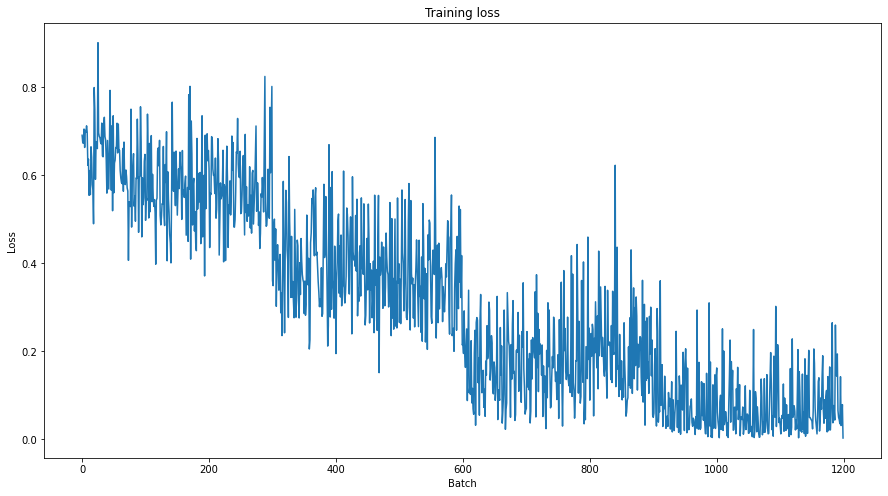

In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

### Post Content

In [ ]:
# install
!pip install pytorch-pretrained-bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
torch.cuda.empty_cache()

In [ ]:
query_data_train = list(final_content_df.Content)
len(query_data_train)

sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]
print(sentences[0])

# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.6188842755253032


Epoch:  20%|██        | 1/5 [02:01<08:07, 121.89s/it]

Validation Accuracy: 0.6748511904761905
Train loss: 0.45094058751049687


Epoch:  40%|████      | 2/5 [04:03<06:05, 121.98s/it]

Validation Accuracy: 0.7165178571428571
Train loss: 0.3093570892588567


Epoch:  60%|██████    | 3/5 [06:06<04:04, 122.45s/it]

Validation Accuracy: 0.7254464285714286
Train loss: 0.21297855290063358


Epoch:  80%|████████  | 4/5 [08:09<02:02, 122.34s/it]

Validation Accuracy: 0.7433035714285714
Train loss: 0.1742726188721293


Epoch: 100%|██████████| 5/5 [10:12<00:00, 122.43s/it]

Validation Accuracy: 0.7232142857142857


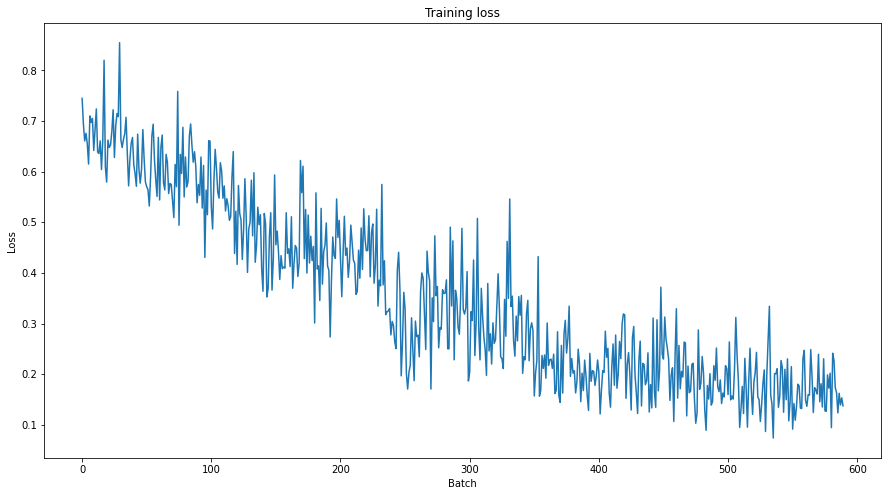

In [ ]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

labels = np.array(final_content_df.label)

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 64

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 5

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##FastText

Most of the code is from here: https://fasttext.cc/docs/en/python-module.html

Additional Resources:    


*   https://fasttext.cc/docs/en/supervised-tutorial.html
*   https://github.com/facebookresearch/fastText




In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(final_title_df, test_size=0.2)

In [ ]:
train_corpus = '\n'.join(list(train.apply(lambda x: "__label__" + df['result'].astype(str) + " " + df['Title'].astype(str))['result']))
test_corpus = '\n'.join(list(test.apply(lambda x: "__label__" + df['result'].astype(str) + " " + df['Title'].astype(str))['result']))

In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 5.4 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3126478 sha256=fd054eb0aa7867d0a03b936c31b5c1ff28d8de7d70469f571145250b86e18d76
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
# Write line to file
with open('train.txt', 'w') as writefile:
    writefile.write(train_corpus)

In [ ]:
with open('test.txt', 'w') as writefile:
    writefile.write(test_corpus)

In [ ]:
import fasttext

model = fasttext.train_supervised('train.txt')

In [ ]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*model.test('test.txt'))

N	11590
P@1	0.567
R@1	0.567


In [ ]:
model.predict("I intend for this post to be the most inspirational post ever made!")

(('__label__inspiring',), array([0.99780071]))

## RoBERTa

Most of the code is from here: https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=WTdfPjhFqExX

Additional resources:    

*   https://pytorch.org/hub/pytorch_fairseq_roberta/
*   https://github.com/pytorch/fairseq/blob/main/examples/roberta/README.md
*   https://huggingface.co/transformers/model_doc/roberta.html



In [ ]:
!pip install transformers==3.0.2

     |████████████████████████████████| 769 kB 8.5 MB/s 
     |████████████████████████████████| 1.2 MB 74.6 MB/s 
     |████████████████████████████████| 3.0 MB 77.3 MB/s 
     |████████████████████████████████| 895 kB 89.4 MB/s 


In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(final_title_df, test_size=0.2)

new_df = final_title_df[['Title', 'label']]

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 128
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Title
        self.targets = self.data.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=200)
test_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN)

FULL Dataset: (10643, 2)
TRAIN Dataset: (8514, 2)
TEST Dataset: (2129, 2)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = RobertaClass()
model.to(device)

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

def calcuate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accuracy(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [ ]:
EPOCHS = 5
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

Training Loss per 5000 steps: 1.575495958328247
Training Accuracy per 5000 steps: 15.625


134it [01:38,  1.37it/s]


The Total Accuracy for Epoch 0: 58.39793281653747
Training Loss Epoch: 0.8027751899477261
Training Accuracy Epoch: 58.39793281653747


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.6095495223999023
Training Accuracy per 5000 steps: 70.3125


134it [01:37,  1.37it/s]


The Total Accuracy for Epoch 1: 70.42518205308903
Training Loss Epoch: 0.5839750608846322
Training Accuracy Epoch: 70.42518205308903


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.48207247257232666
Training Accuracy per 5000 steps: 76.5625


134it [01:37,  1.38it/s]


The Total Accuracy for Epoch 2: 76.33309842612168
Training Loss Epoch: 0.5042654611726305
Training Accuracy Epoch: 76.33309842612168


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.391433447599411
Training Accuracy per 5000 steps: 81.25


134it [01:37,  1.38it/s]


The Total Accuracy for Epoch 3: 80.62015503875969
Training Loss Epoch: 0.43012176832156396
Training Accuracy Epoch: 80.62015503875969


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.43503642082214355
Training Accuracy per 5000 steps: 82.8125


134it [01:37,  1.38it/s]

The Total Accuracy for Epoch 4: 85.04815597838854
Training Loss Epoch: 0.3476261900209669
Training Accuracy Epoch: 85.04815597838854


# Sentiment Analysis

## Sentiment with Empath

### Set things up and test the logic

In [ ]:
!pip install empath
!pip install praw

In [ ]:
#Test Python Reddit API Wrapper

import praw

reddit = praw.Reddit(client_id='F77JkePeSXMBgL_u3m9CBQ',
                     client_secret='DgQrUlyRndRlDYapNRD6GcOr_D_Vsg',
                     user_agent='smm_project_21',
                     check_for_async=False)

submissions = reddit.subreddit('opensource').hot(limit=5)
[str(x) for x in submissions]

['qqs3ey', 'qqn87h', 'qqr7us', 'qqvrhz', 'qqwwci']

In [ ]:
submission = reddit.submission(id='6e1ovf')

In [ ]:
from empath import Empath
lexicon = Empath()

In [ ]:
from praw.models import MoreComments

sentiments = []
comments = []

for top_level_comment in submission.comments:
    if isinstance(top_level_comment, MoreComments):
        continue

    sentiment = lexicon.analyze(top_level_comment.body,
                                                      #categories=["positive_emotion", "negative_emotion"],
                                                      normalize=True)
    print(type(sentiment))
    print("COMMENT SENTIMENT: " + str(sentiment))
    sentiments.append(list(sentiment.values()))
    comments.append(top_level_comment.body)

<class 'dict'>
COMMENT SENTIMENT: {'help': 0.0, 'office': 0.0, 'dance': 0.0, 'money': 0.0, 'wedding': 0.0, 'domestic_work': 0.0, 'sleep': 0.0, 'medical_emergency': 0.0, 'cold': 0.0, 'hate': 0.0, 'cheerfulness': 0.0, 'aggression': 0.0, 'occupation': 0.0, 'envy': 0.0, 'anticipation': 0.0, 'family': 0.0, 'vacation': 0.0, 'crime': 0.0, 'attractive': 0.0, 'masculine': 0.0, 'prison': 0.0, 'health': 0.0, 'pride': 0.0, 'dispute': 0.0, 'nervousness': 0.0, 'government': 0.0, 'weakness': 0.0, 'horror': 0.0, 'swearing_terms': 0.0, 'leisure': 0.0, 'suffering': 0.0, 'royalty': 0.0, 'wealthy': 0.0, 'tourism': 0.0, 'furniture': 0.0, 'school': 0.0, 'magic': 0.0, 'beach': 0.0, 'journalism': 0.0, 'morning': 0.0, 'banking': 0.0, 'social_media': 0.0, 'exercise': 0.0, 'night': 0.0, 'kill': 0.0, 'blue_collar_job': 0.0, 'art': 0.0, 'ridicule': 0.0, 'play': 0.0, 'computer': 0.0, 'college': 0.0, 'optimism': 0.0, 'stealing': 0.0, 'real_estate': 0.0, 'home': 0.0, 'divine': 0.0, 'sexual': 0.0, 'fear': 0.0, 'irrita

In [ ]:
from scipy import spatial

1 - spatial.distance.cosine(sentiments[1], sentiments[2])

0.2972016950918206

In [ ]:
!pip install transformers
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Compare Sentiment Similarity with Semantic Similarity with sentence_transformers

sentence1 = comments[1]
sentence2 = comments[2]
# encode sentences to get their embeddings
embedding1 = model.encode(sentence1, convert_to_tensor=True)
embedding2 = model.encode(sentence2, convert_to_tensor=True)
# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
print("Sentence 1:", sentence1)
print("Sentence 2:", sentence2)
print("Similarity score:", cosine_scores.item())

Sentence 1: Maybe it is a good idea to qualify the claim that for Kant religion stems from knowledge. Religion as such is distinguished from knowledge of phenomena that come to us through the Anschauungsformen (space and time). Religious phenomena tend to transcend the limits of sensory perception and thus fall outside of the limits Kant set in the first critique. One famous quote of Kant is: "I had to deny knowledge in order to make room for faith." (From the top of my mind: he wrote this in the first critique.)
Sentence 2: I know someone already fleshed the answer out pretty well but I can give some more specific information on the subject. 

Nietzsche's main religion that he spoke of was Christianity and he said it arose out of the aforementioned resentment. The Roman Empire was a much larger empire than that of Judah(present-day Israel) and so Rome could easily enforce its law upon the people of Judah. Their ideals conflicted so the slaves of Israel concocted a religion, Christiani

In [ ]:
from numpy import dot
from numpy.linalg import norm

def cosine_sim(a,b):
  return dot(a, b)/(norm(a)*norm(b))

In [ ]:
import numpy as np
import scipy.sparse

post = '16f6iy'
submission = reddit.submission(id = post)
empath_inspiring = {}
empath_inspiring[post] = {}

total_similarity = 0
i=0
zero_flag = False

for top_level_comment in submission.comments:
    if isinstance(top_level_comment, MoreComments):
        continue
        
    if i == 0:
      top_comment = top_level_comment.body
      sentiment_1 = np.array(list(lexicon.analyze(top_level_comment.body,
                                                  #categories=["positive_emotion", "negative_emotion"],
                                                  normalize=True
                                         ).values()))
    if not np.any(sentiment_1):
      print("Top comment is a zero vector")
      empath_inspiring = empath_inspiring.pop(post)
      zero_flag = True
      break

    #print(top_level_comment.body)
    sentiment_2 = np.array(list(lexicon.analyze(top_level_comment.body,
                                                  #categories=["positive_emotion", "negative_emotion"],
                                                  normalize=True
                                         ).values()))
    if not np.any(sentiment_2):
      print("lower comment is zero vector")
      continue
    
    cosine_score = 1 - cosine_sim(sentiment_1, sentiment_2)

    if i > 0:
      total_similarity += cosine_score.item()

    i += 1

if not zero_flag:
  try:
    empath_inspiring[post]['average_similarity'] = total_similarity/(i-1)
    empath_inspiring[post]['total_similarity'] = total_similarity
    empath_inspiring[post]['total_comments'] = i
  except:
    print('not enough comments')

Top comment is a zero vector


### Do It

In [ ]:
import pandas as pd

df = pd.read_csv('data_all_post_ids.csv')

inspiring_list = list(df['inspiring'].sample(5000, random_state = 42))
not_inspiring_list = list(df['not inspiring'].sample(5000, random_state=42))

In [ ]:
import numpy as np
import scipy.sparse


empath_inspiring = {}

x=0

for post in tqdm(inspiring_list):
  total_similarity = 0
  i=0
  zero_flag = False

  try:
    submission = reddit.submission(id = post)
    empath_inspiring[post] = {}
  except:
    continue

  try: 
    for top_level_comment in submission.comments:
        if isinstance(top_level_comment, MoreComments):
            continue
            
        if i == 0:
          top_comment = top_level_comment.body
          sentiment_1 = np.array(list(lexicon.analyze(top_level_comment.body,
                                                      #categories=["positive_emotion", "negative_emotion"],
                                                      normalize=True
                                            ).values()))
          if not np.any(sentiment_1):
            #print("Top comment is a zero vector")
            empath_inspiring = empath_inspiring.pop(post)
            zero_flag = True
            break
        
        #print(top_level_comment.body)
        sentiment_2 = np.array(list(lexicon.analyze(top_level_comment.body,
                                                      #categories=["positive_emotion", "negative_emotion"],
                                                      normalize=True
                                            ).values()))
        if not np.any(sentiment_2):
          #print("lower comment is zero vector")
          continue
        
        cosine_score = 1 - cosine_sim(sentiment_1, sentiment_2)

        if i > 0:
          total_similarity += cosine_score.item()

        i += 1
  except:
    empath_inspiring = empath_inspiring.pop(post)
    #print('error with the submission')
    continue

  if not zero_flag:
    try:
      empath_inspiring[post]['average_similarity'] = total_similarity/(i-1)
      empath_inspiring[post]['total_similarity'] = total_similarity
      empath_inspiring[post]['total_comments'] = i
    except:
      empath_inspiring = empath_inspiring.pop(post)
      #print('not enough comments')

  if len(empath_inspiring) == 1000:
    break

#  if x>10:
#    break
#  x+=1

 79%|███████▉  | 3956/5000 [2:26:29<33:10,  1.91s/it]

### Analysis

In [ ]:
import json as JSON

with open('empath_not_inspiring.json') as json_file:
    print(type(json_file))
    not_inspiring_posts = JSON.load(json_file)

n_similarities = []
n_num_posts = []
n_total_similarities = []
for d in not_inspiring_posts:
  try:
    n_similarities.append(not_inspiring_posts[d]['average_similarity'])
    n_num_posts.append(not_inspiring_posts[d]['total_comments'])
    n_total_similarities.append(not_inspiring_posts[d]['total_similarity'])
  except:
    continue

<class '_io.TextIOWrapper'>


In [ ]:
with open('empath_inspiring.json') as json_file:
    print(type(json_file))
    inspiring_posts = JSON.load(json_file)

i_similarities = []
i_num_posts = []
i_total_similarities = []
for d in inspiring_posts:
  try:
    i_similarities.append(inspiring_posts[d]['average_similarity'])
    i_num_posts.append(inspiring_posts[d]['total_comments'])
    i_total_similarities.append(inspiring_posts[d]['total_similarity'])
  except:
    continue

<class '_io.TextIOWrapper'>


In [ ]:
import numpy as np

print(f"Average similarity for uninspiring posts: {np.sum(n_total_similarities)/np.sum(n_num_posts)}")
print(f"Average similarity for INSPIRING posts: {np.sum(i_total_similarities)/ np.sum(i_num_posts)}")

Average similarity for uninspiring posts: 0.8026516816476243
Average similarity for INSPIRING posts: 0.8276893720332691


In [ ]:
from scipy import stats
from scipy.stats import norm

stats.ttest_ind(i_similarities, n_similarities, equal_var=False)

Ttest_indResult(statistic=-1.5773687431358436, pvalue=0.11497559663223486)

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(n_similarities)
print("stat", stat)
print("p", p)

stat 0.91080242395401
p 4.856185444547319e-20


In [ ]:
len(i_similarities)

663

In [ ]:
len(n_similarities)

714

In [ ]:
import random

i = i_similarities
n = random.sample(n_similarities, 663)

In [ ]:
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(i, n)

In [ ]:
U1

212546.0

In [ ]:
p

0.14955896319772005

Text(0, 0.5, 'Count')

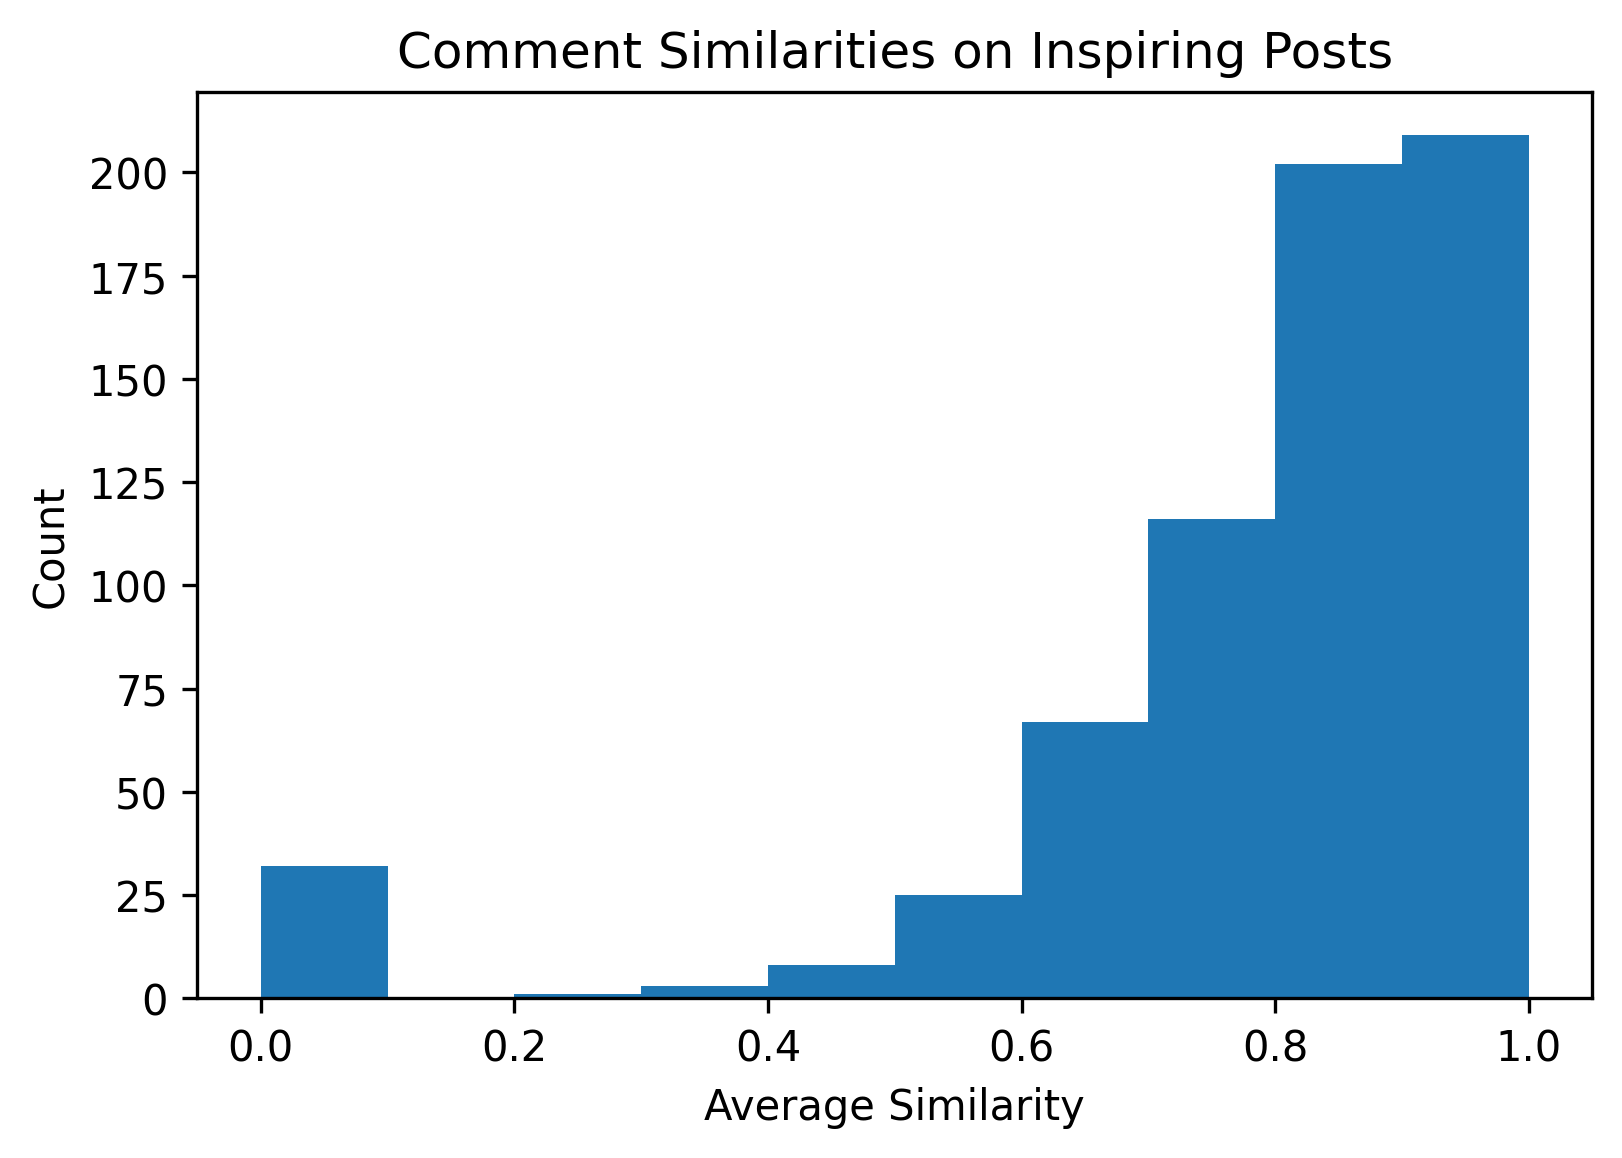

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300

#plt.figure(figsize=(10,8))
plt.hist(i_similarities, bins=10)
plt.title("Comment Similarities on Inspiring Posts")
plt.xlabel("Average Similarity")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

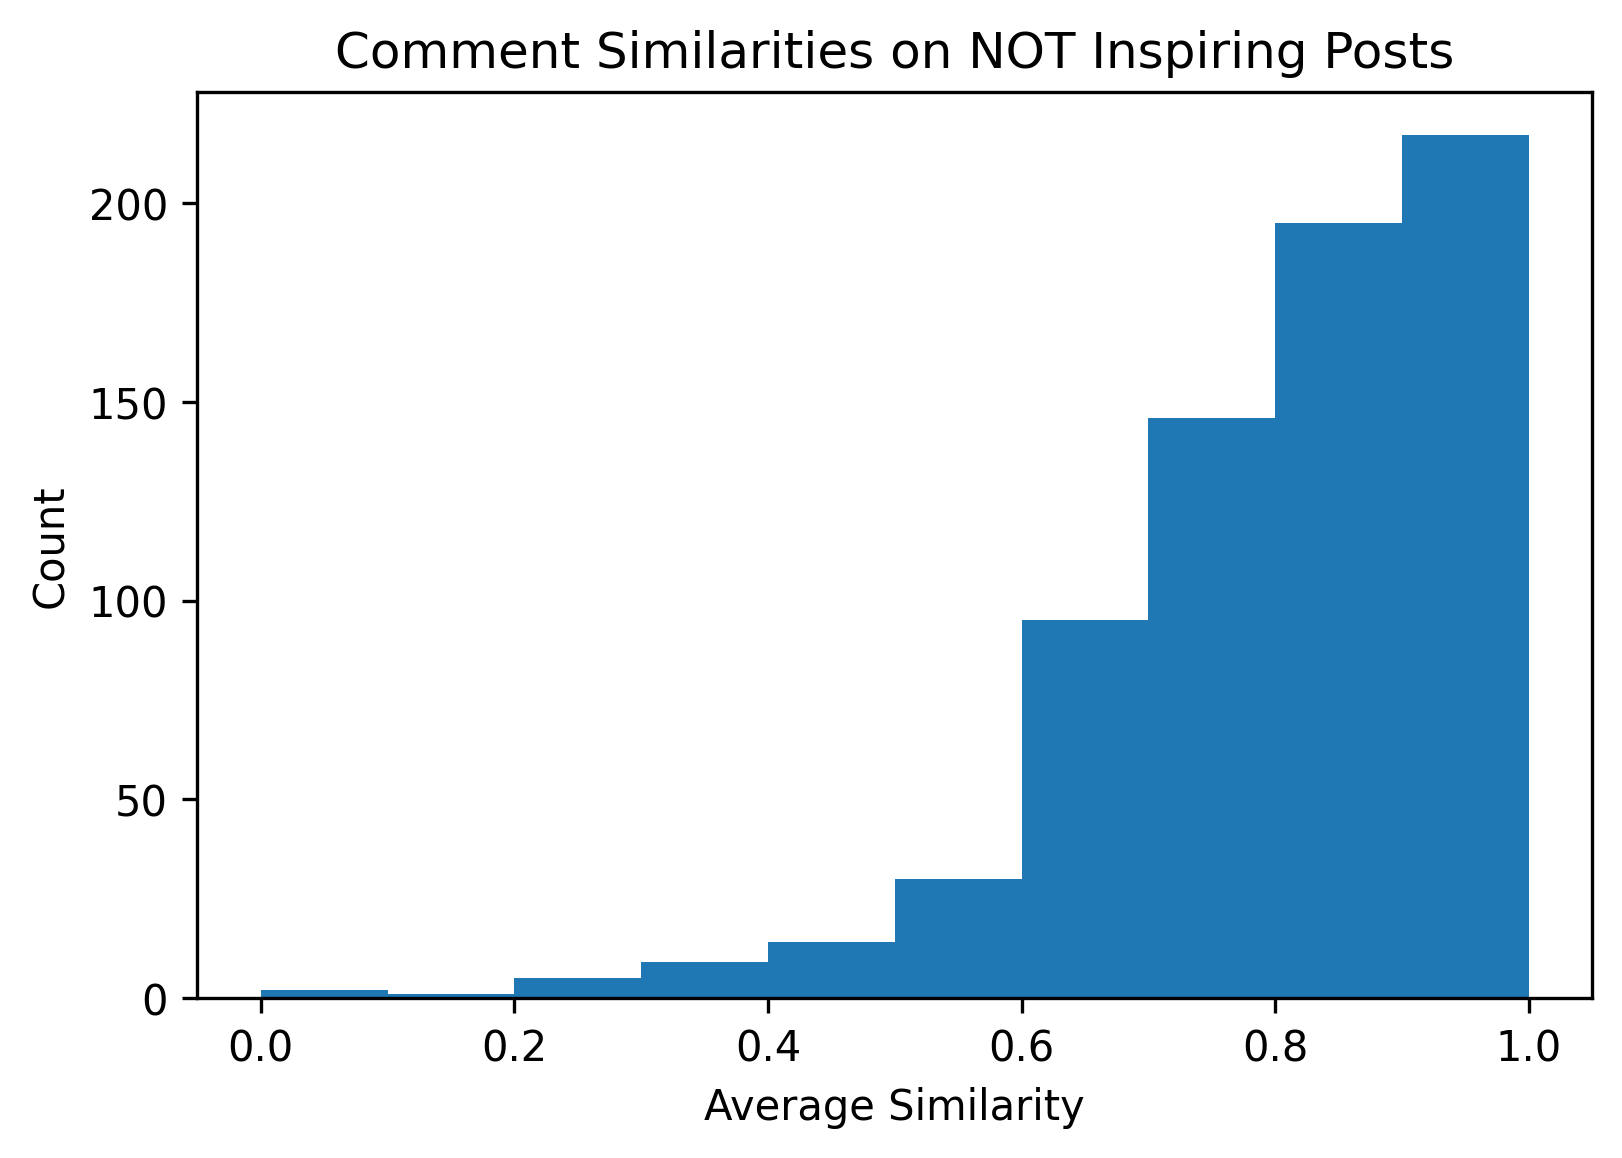

In [ ]:
#plt.figure(figsize=(10,8))
plt.hist(n_similarities, bins=10)
plt.title("Comment Similarities on NOT Inspiring Posts")
plt.xlabel("Average Similarity")
plt.ylabel("Count")

Text(0, 0.5, 'Average Similarity for Post')

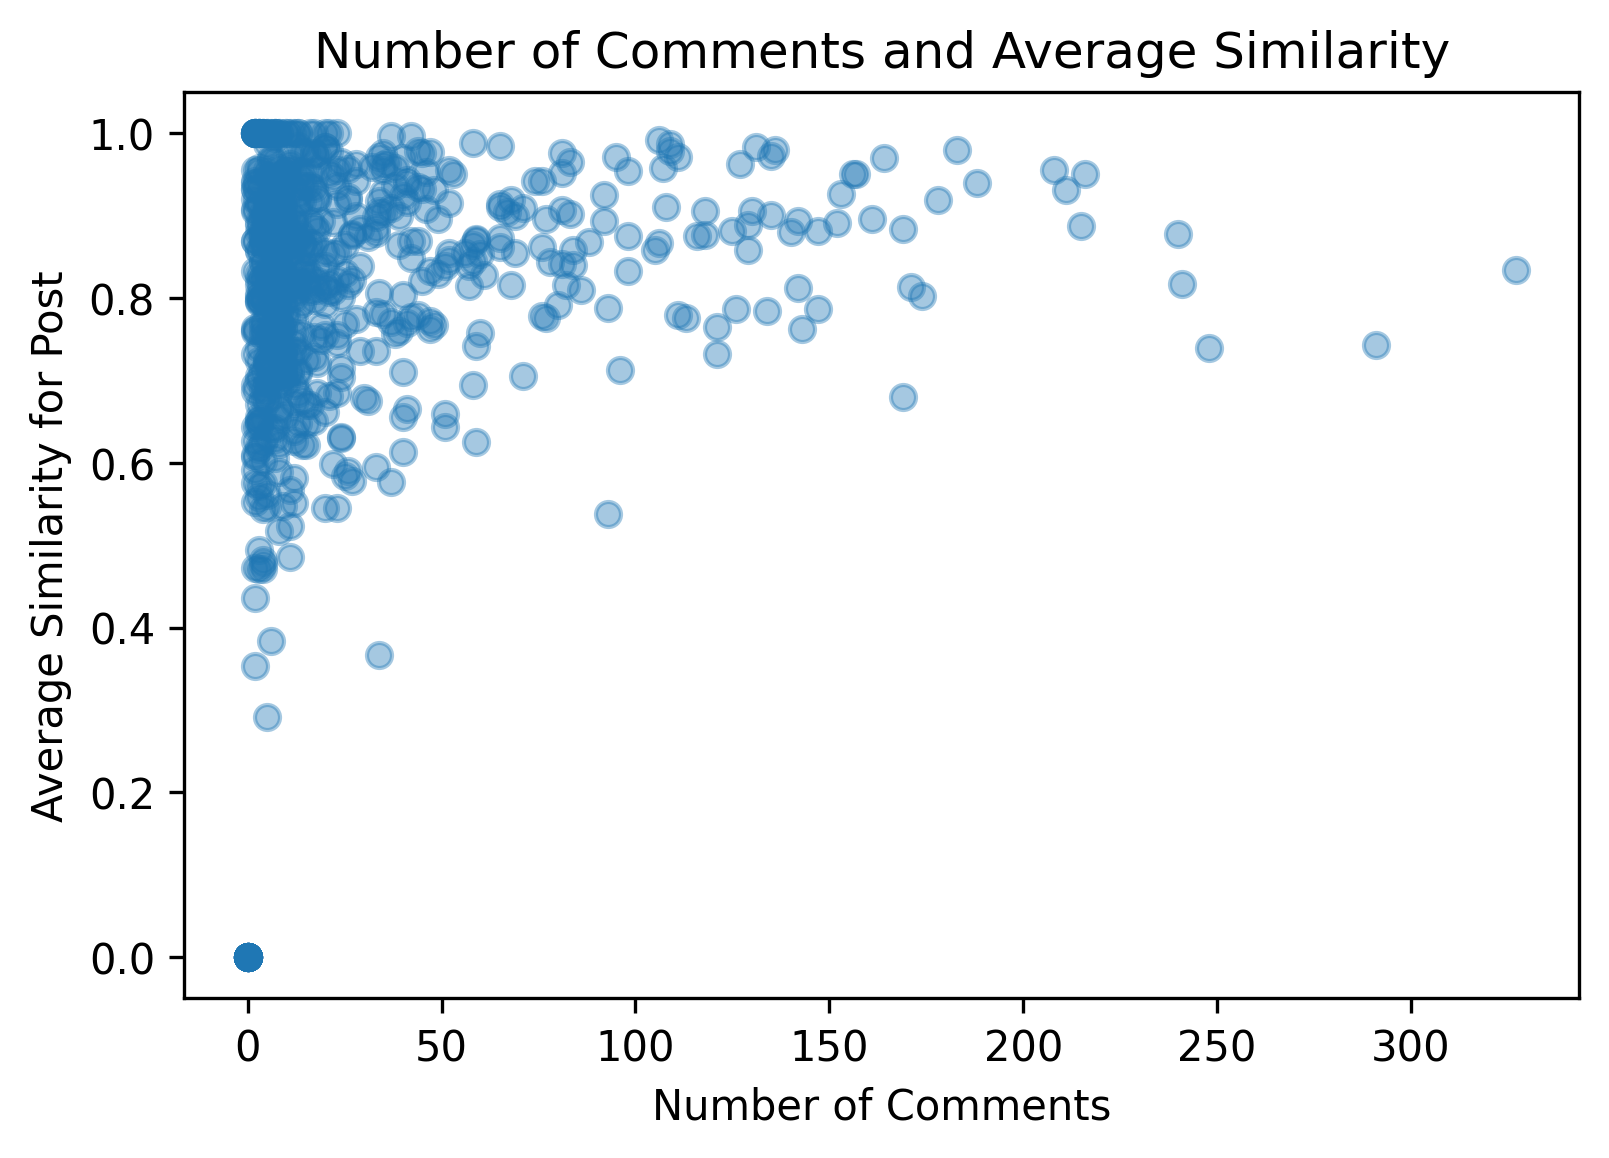

In [ ]:
#plt.figure(figsize=(10,8))
plt.scatter(i_num_posts, i_similarities, alpha=.4)
plt.title("Number of Comments and Average Similarity")
plt.xlabel("Number of Comments")
plt.ylabel("Average Similarity for Post")

## Semantic Cosine Similarity with sentence_transformers

Source: https://towardsdatascience.com/semantic-similarity-using-transformers-8f3cb5bf66d6

### Set things up and test the logic

In [ ]:
!pip install transformers
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer, util
import numpy as np

model = SentenceTransformer('stsb-roberta-large')

sentence1 = "I like Python because I can build AI applications"
sentence2 = "I like Python because I can do data analytics"
# encode sentences to get their embeddings
embedding1 = model.encode(sentence1, convert_to_tensor=True)
embedding2 = model.encode(sentence2, convert_to_tensor=True)
# compute similarity scores of two embeddings
cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
print("Sentence 1:", sentence1)
print("Sentence 2:", sentence2)
print("Similarity score:", cosine_scores.item())

Sentence 1: I like Python because I can build AI applications
Sentence 2: I like Python because I can do data analytics
Similarity score: 0.8015278577804565


In [ ]:
#Test before doing the big loop

from praw.models import MoreComments

submission = reddit.submission(id='6e1ovf')

inspiring_posts = {'6e1ovf':{'total_similarity': 0, 'average_similarity': 0, 'total_comments': 0}}

total_similarity = 0

i=0

for top_level_comment in submission.comments:
    if isinstance(top_level_comment, MoreComments):
        continue
    if i == 0:
      top_comment = top_level_comment.body
      embedding1 = model.encode(top_comment, convert_to_tensor=True)
    
    print(i, top_level_comment)
    #print(top_level_comment.body)
    embedding2 = model.encode(top_level_comment.body, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
    print("COMMENT SIMILARITY: " + str(cosine_scores.item()))

    if i > 0:
      total_similarity += cosine_scores.item()

    i += 1

inspiring_posts['6e1ovf']['total_similarity'] = total_similarity
inspiring_posts['6e1ovf']['average_similarity'] = total_similarity/(i-1)
inspiring_posts['6e1ovf']['total_comments'] = i

print(i-1,total_similarity, total_similarity/i)

In [ ]:
inspiring_posts

{'6e1ovf': {'average_similarity': 0.013247789815068245,
  'total_comments': 3,
  'total_similarity': 0.02649557963013649}}

### Grab the Posts and Do It

In [ ]:
import pandas as pd

df = pd.read_csv('data_all_post_ids.csv')

inspiring_list = list(df['inspiring'].sample(1500, random_state = 42))
not_inspiring_list = list(df['not inspiring'].sample(1500, random_state=42))

In [ ]:
!pip install praw
import praw
from praw.models import MoreComments

reddit = praw.Reddit(client_id='F77JkePeSXMBgL_u3m9CBQ',
                     client_secret='DgQrUlyRndRlDYapNRD6GcOr_D_Vsg',
                     user_agent='smm_project_21',
                     check_for_async=False)

     |████████████████████████████████| 167 kB 5.1 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 


In [ ]:
not_inspiring_posts = {}


for post in not_inspiring_list:

  try:
    submission = reddit.submission(id = post)
    not_inspiring_posts[post] = {}

    total_similarity = 0
    i=0

    for top_level_comment in submission.comments:
        if isinstance(top_level_comment, MoreComments):
            continue
        if i == 0:
          top_comment = top_level_comment.body
          embedding1 = model.encode(top_comment, convert_to_tensor=True)
        
        #print(i, top_level_comment)
        #print(top_level_comment.body)

        embedding2 = model.encode(top_level_comment.body, convert_to_tensor=True)
        cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
        #print("COMMENT SIMILARITY: " + str(cosine_scores.item()))

        if i > 0:
          total_similarity += cosine_scores.item()

        i += 1

    not_inspiring_posts[post]['average_similarity'] = total_similarity/(i-1)
    not_inspiring_posts[post]['total_similarity'] = total_similarity
    not_inspiring_posts[post]['total_comments'] = i

  except:
    continue

  if len(not_inspiring_posts) == 1000:
    break

# load json module
import json

# create json object from dictionary
json = json.dumps(not_inspiring_posts)

# open file for writing, "w" 
f = open("not_inspiring.json","w")

# write json object to file
f.write(json)

# close file
f.close()

In [ ]:
inspiring_posts = {}


for post in inspiring_list:

  try:
    submission = reddit.submission(id = post)
    inspiring_posts[post] = {}

    total_similarity = 0
    i=0

    for top_level_comment in submission.comments:
        if isinstance(top_level_comment, MoreComments):
            continue
        if i == 0:
          top_comment = top_level_comment.body
          embedding1 = model.encode(top_comment, convert_to_tensor=True)
        
        #print(i, top_level_comment)
        #print(top_level_comment.body)

        embedding2 = model.encode(top_level_comment.body, convert_to_tensor=True)
        cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
        #print("COMMENT SIMILARITY: " + str(cosine_scores.item()))

        if i > 0:
          total_similarity += cosine_scores.item()

        i += 1

    inspiring_posts[post]['average_similarity'] = total_similarity/(i-1)
    inspiring_posts[post]['total_similarity'] = total_similarity
    inspiring_posts[post]['total_comments'] = i

  except:
    continue

  if len(inspiring_posts) == 1000:
    break

# load json module
import json

# create json object from dictionary
json = json.dumps(inspiring_posts)

# open file for writing, "w" 
f = open("inspiring.json","w")

# write json object to file
f.write(json)

# close file
f.close()

In [ ]:
from google.colab import files

files.download('inspiring.json')
files.download('not_inspiring.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Analysis

In [ ]:
import json as JSON

with open('not_inspiring.json') as json_file:
    print(type(json_file))
    not_inspiring_posts = JSON.load(json_file)

n_similarities = []
n_num_posts = []
n_total_similarities = []
for d in not_inspiring_posts:
  try:
    n_similarities.append(not_inspiring_posts[d]['average_similarity'])
    n_num_posts.append(not_inspiring_posts[d]['total_comments'])
    n_total_similarities.append(not_inspiring_posts[d]['total_similarity'])
  except:
    continue

<class '_io.TextIOWrapper'>


In [ ]:
with open('inspiring.json') as json_file:
    print(type(json_file))
    inspiring_posts = JSON.load(json_file)

i_similarities = []
i_num_posts = []
i_total_similarities = []
for d in inspiring_posts:
  try:
    i_similarities.append(inspiring_posts[d]['average_similarity'])
    i_num_posts.append(inspiring_posts[d]['total_comments'])
    i_total_similarities.append(inspiring_posts[d]['total_similarity'])
  except:
    continue

<class '_io.TextIOWrapper'>


In [ ]:
import numpy as np

print(f"Average similarity for uninspiring posts: {np.sum(n_total_similarities)/np.sum(n_num_posts)}")
print(f"Average similarity for INSPIRING posts: {np.sum(i_total_similarities)/ np.sum(i_num_posts)}")

Average similarity for uninspiring posts: 0.26342921379342066
Average similarity for INSPIRING posts: 0.2546113555834002


Unweighted average of averages

Average similarity for uninspiring posts: 0.3269830038211771

Average similarity for INSPIRING posts: 0.28586769655973016

In [ ]:
from scipy import stats
from scipy.stats import norm

stats.ttest_ind(i_similarities, n_similarities, equal_var=False)

Ttest_indResult(statistic=-6.410387284926329, pvalue=1.8400476293273957e-10)

In [ ]:
np.max(i_similarities)

0.8019356245503706

In [ ]:
np.median(n_similarities)

0.32971809970008004

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(i_similarities)
print("stat", stat)
print("p", p)

stat 0.9927340149879456
p 0.00018608762184157968


Text(0, 0.5, 'Count')

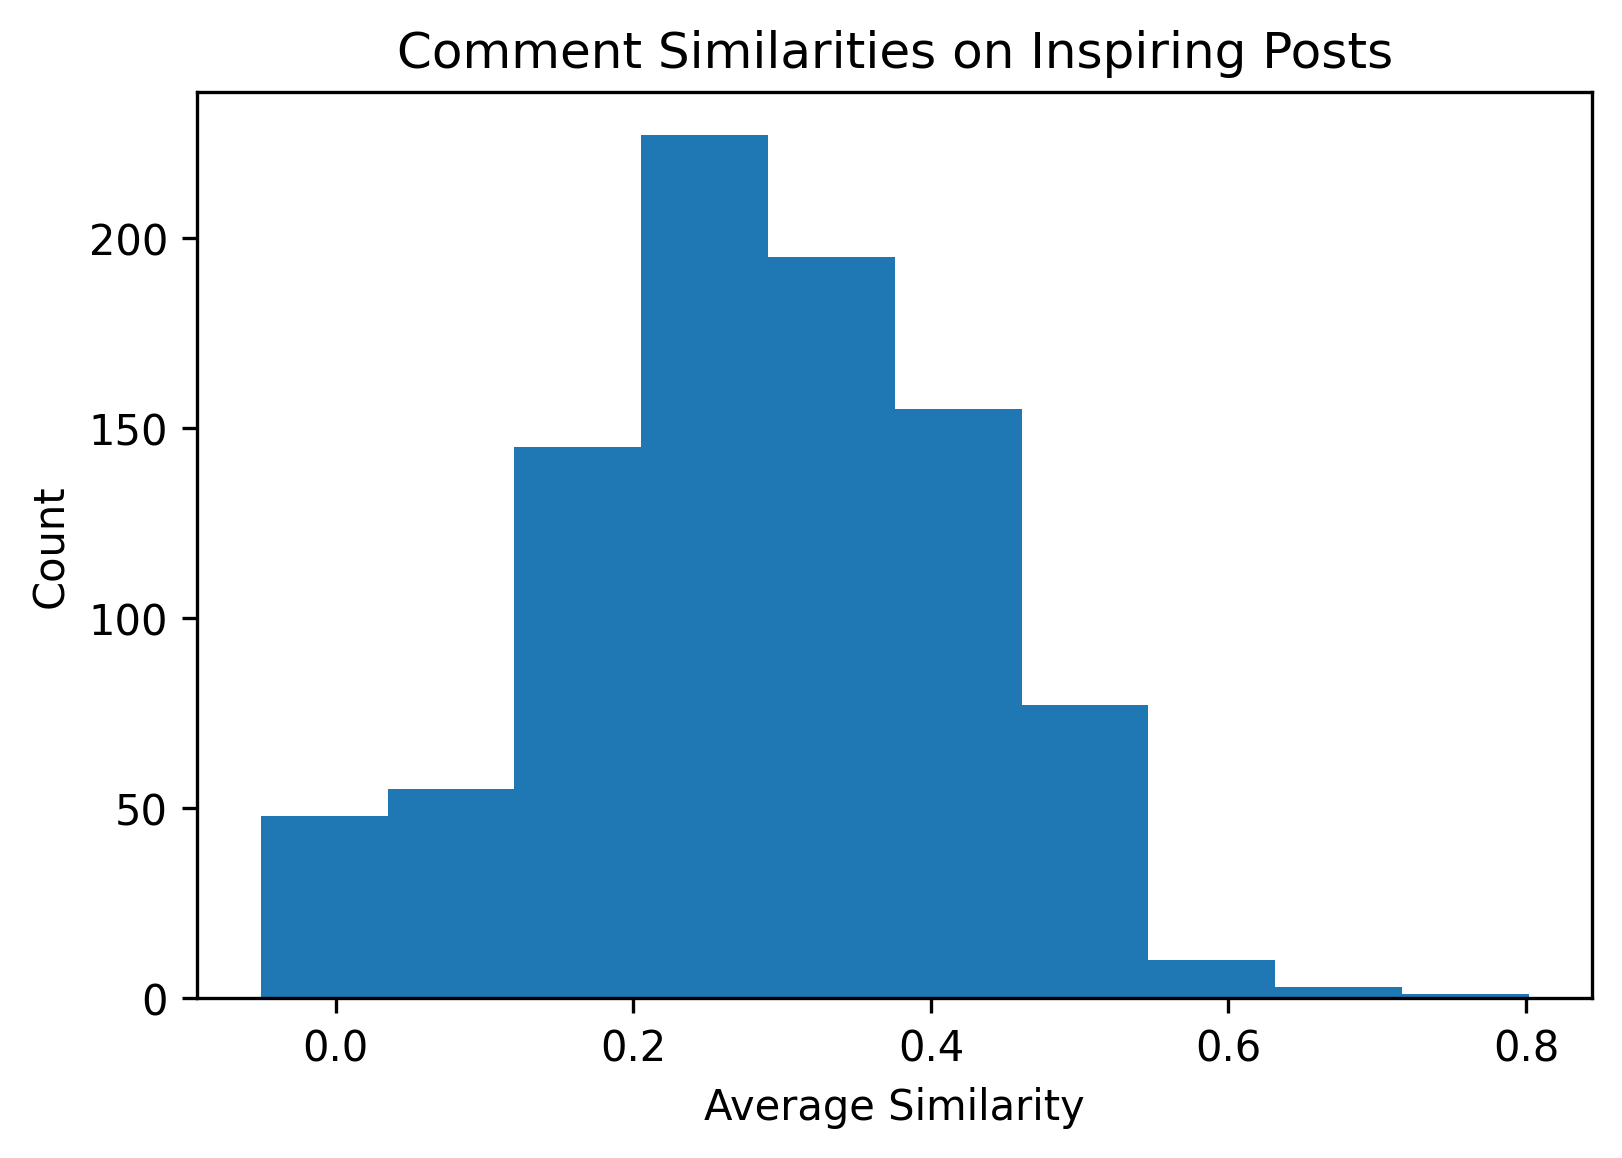

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300

#plt.figure(figsize=(10,8))
plt.hist(i_similarities, bins=10)
plt.title("Comment Similarities on Inspiring Posts")
plt.xlabel("Average Similarity")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

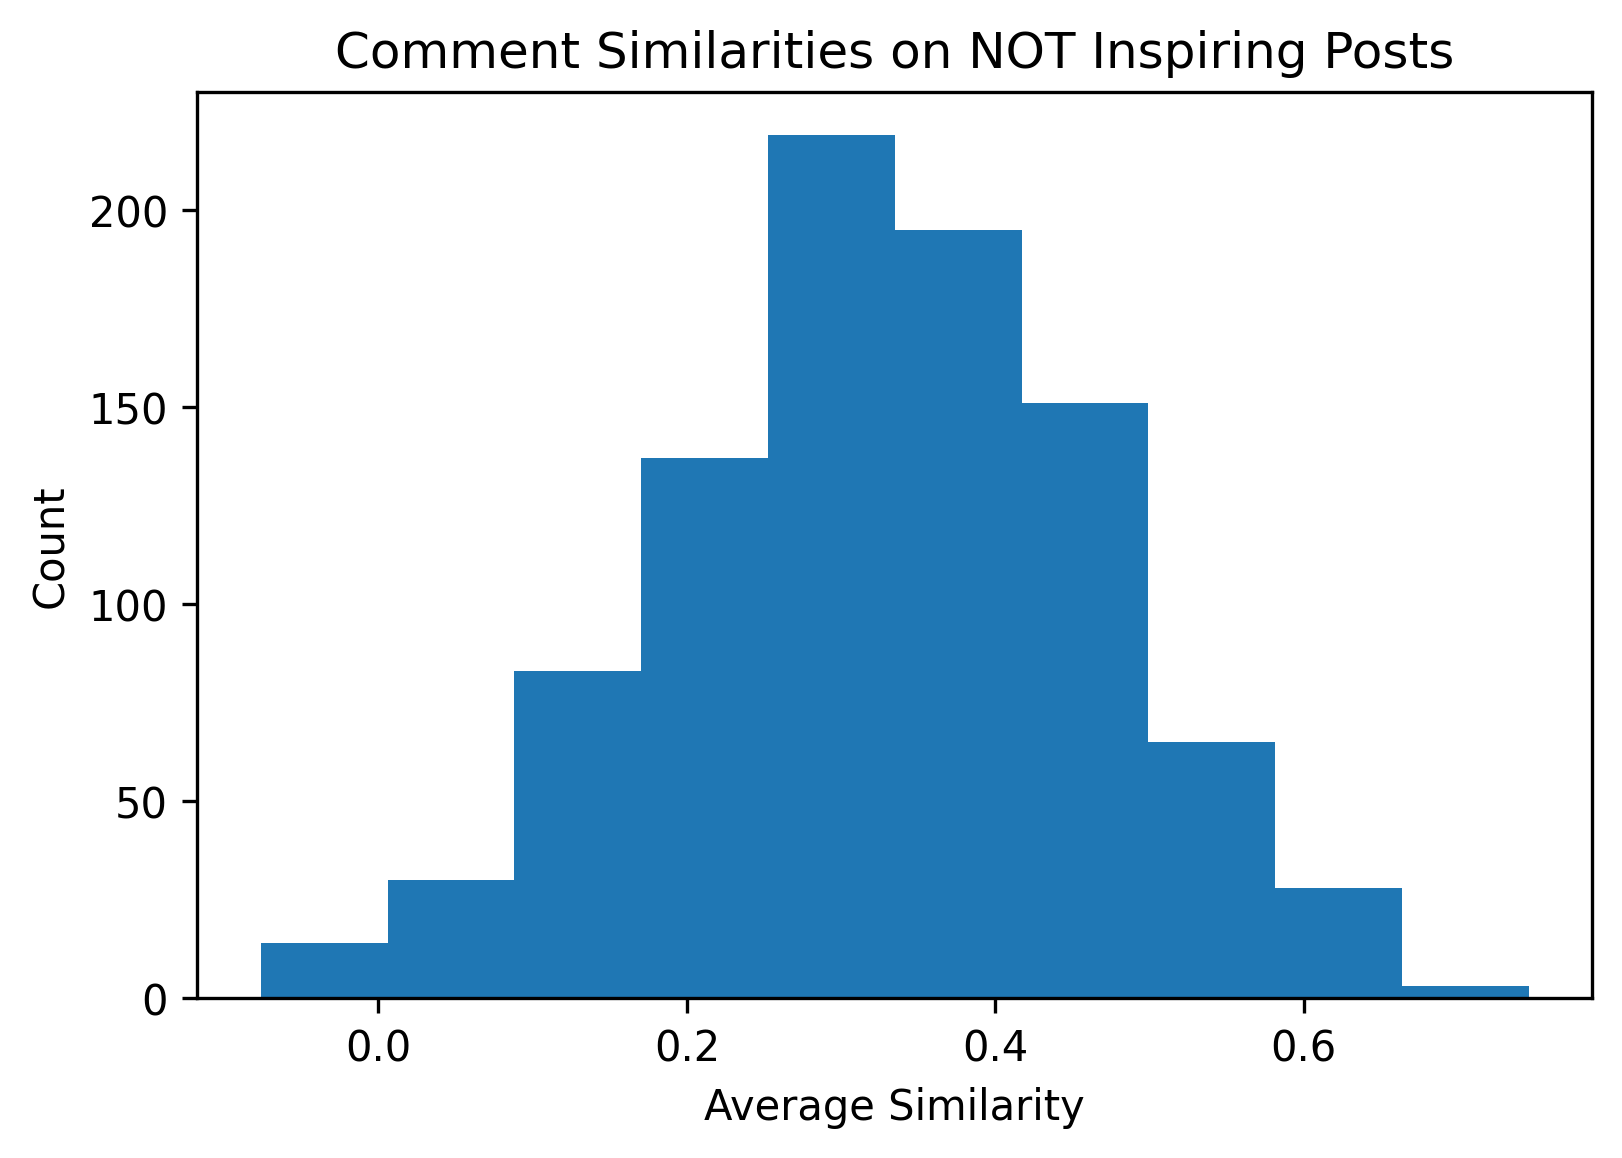

In [ ]:
#plt.figure(figsize=(10,8))
plt.hist(n_similarities, bins=10)
plt.title("Comment Similarities on NOT Inspiring Posts")
plt.xlabel("Average Similarity")
plt.ylabel("Count")

Text(0, 0.5, 'Average Similarity for Post')

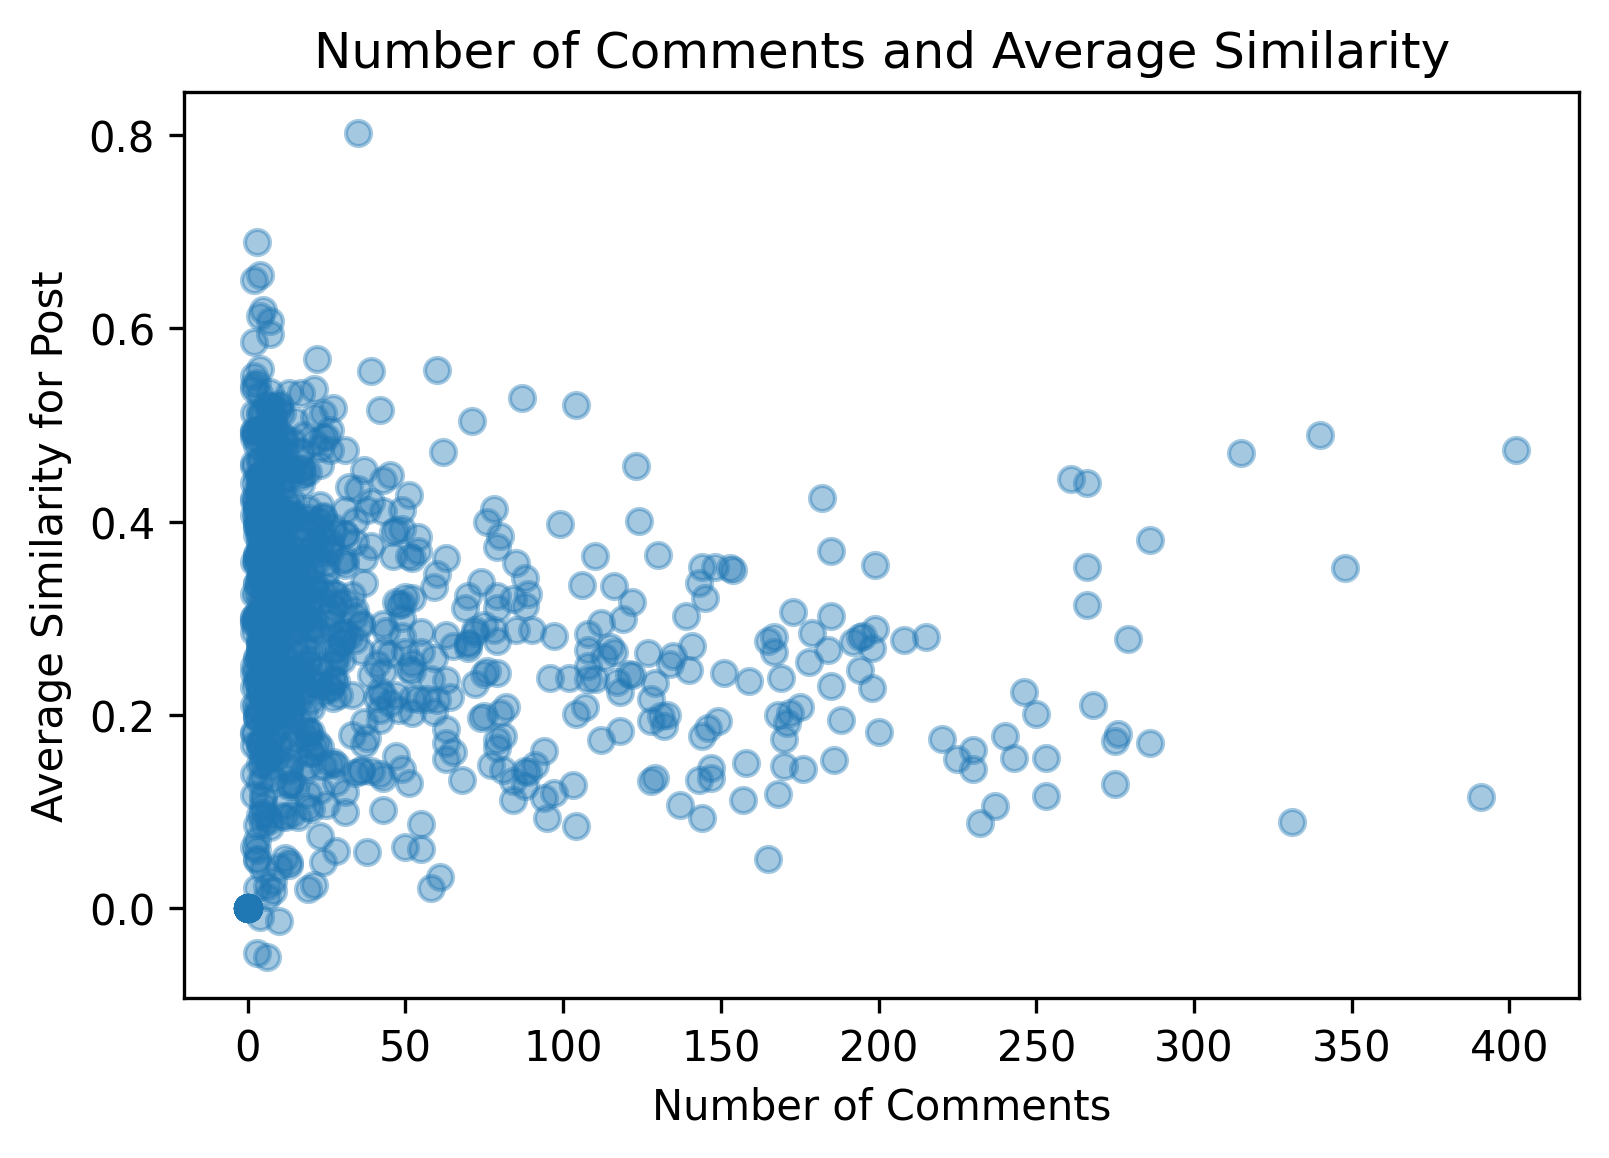

In [ ]:
#plt.figure(figsize=(10,8))
plt.scatter(i_num_posts, i_similarities, alpha=.4)
plt.title("Number of Comments and Average Similarity")
plt.xlabel("Number of Comments")
plt.ylabel("Average Similarity for Post")

In [ ]:
!pip install powerlaw
import powerlaw

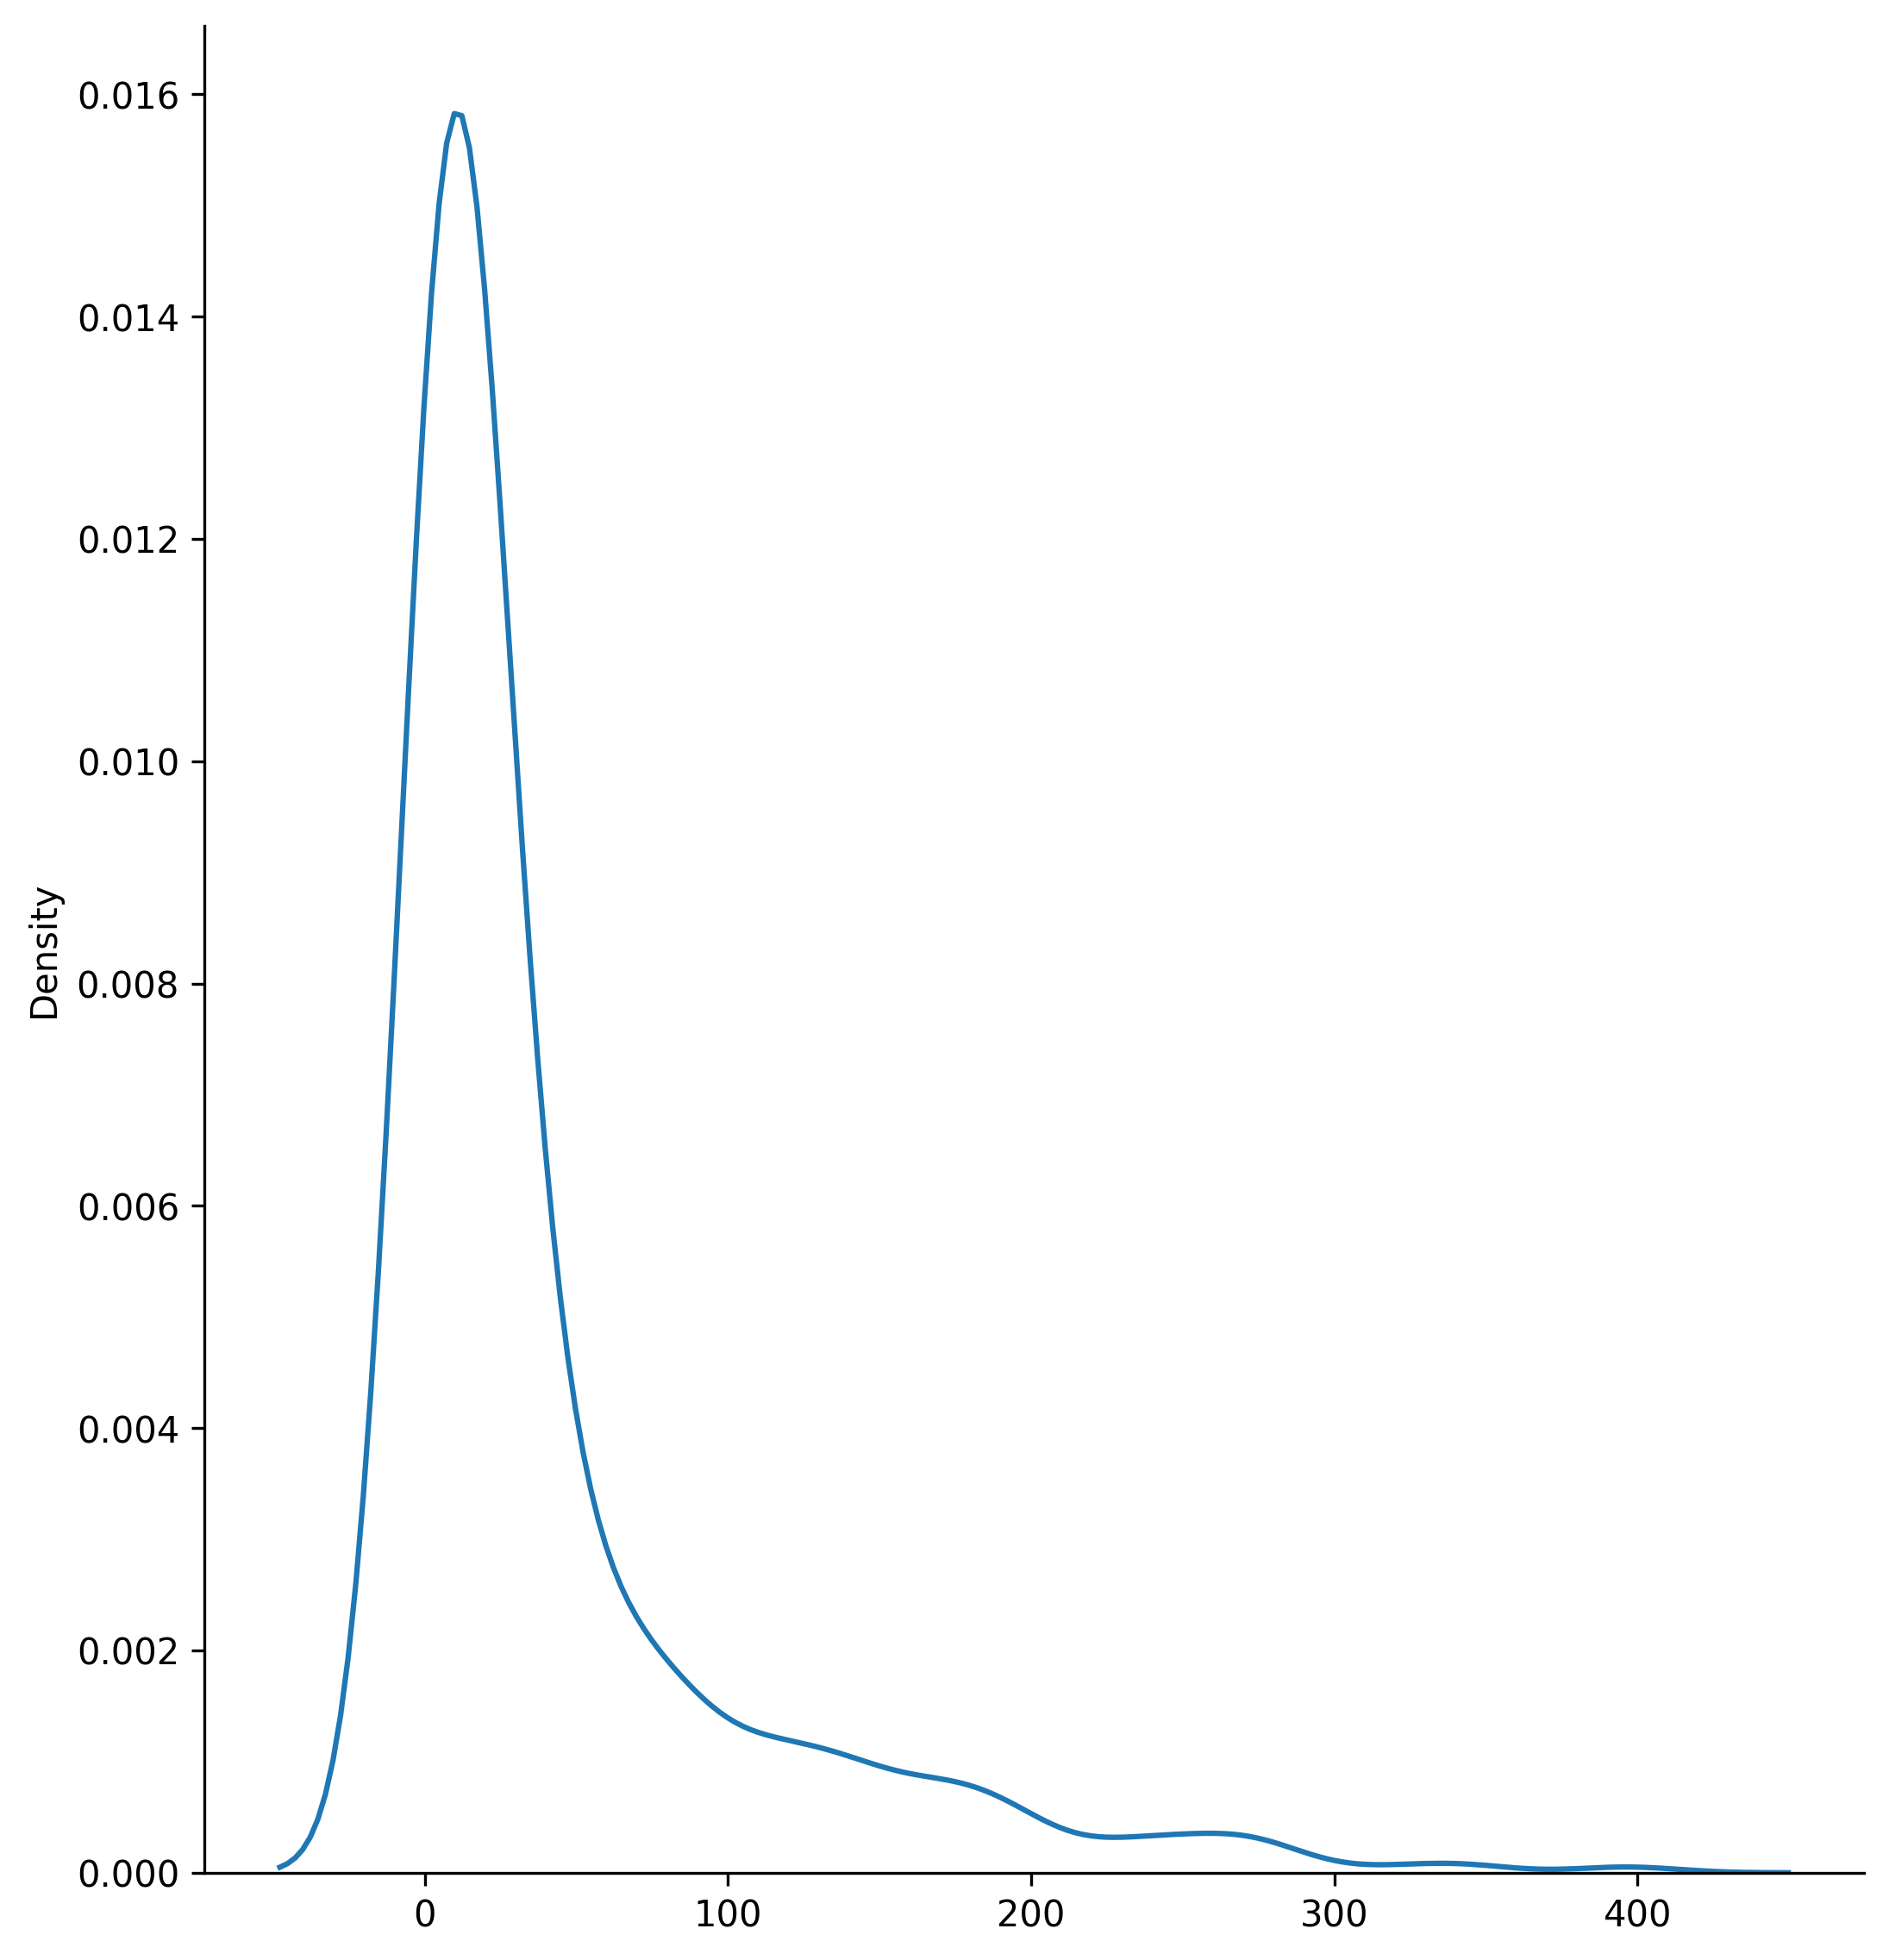

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


p = sns.displot(x=i_num_posts, kind='kde')
p.fig.set_size_inches(8, 8)

Calculating best minimal value for power law fit
1.9846115496603973
16.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


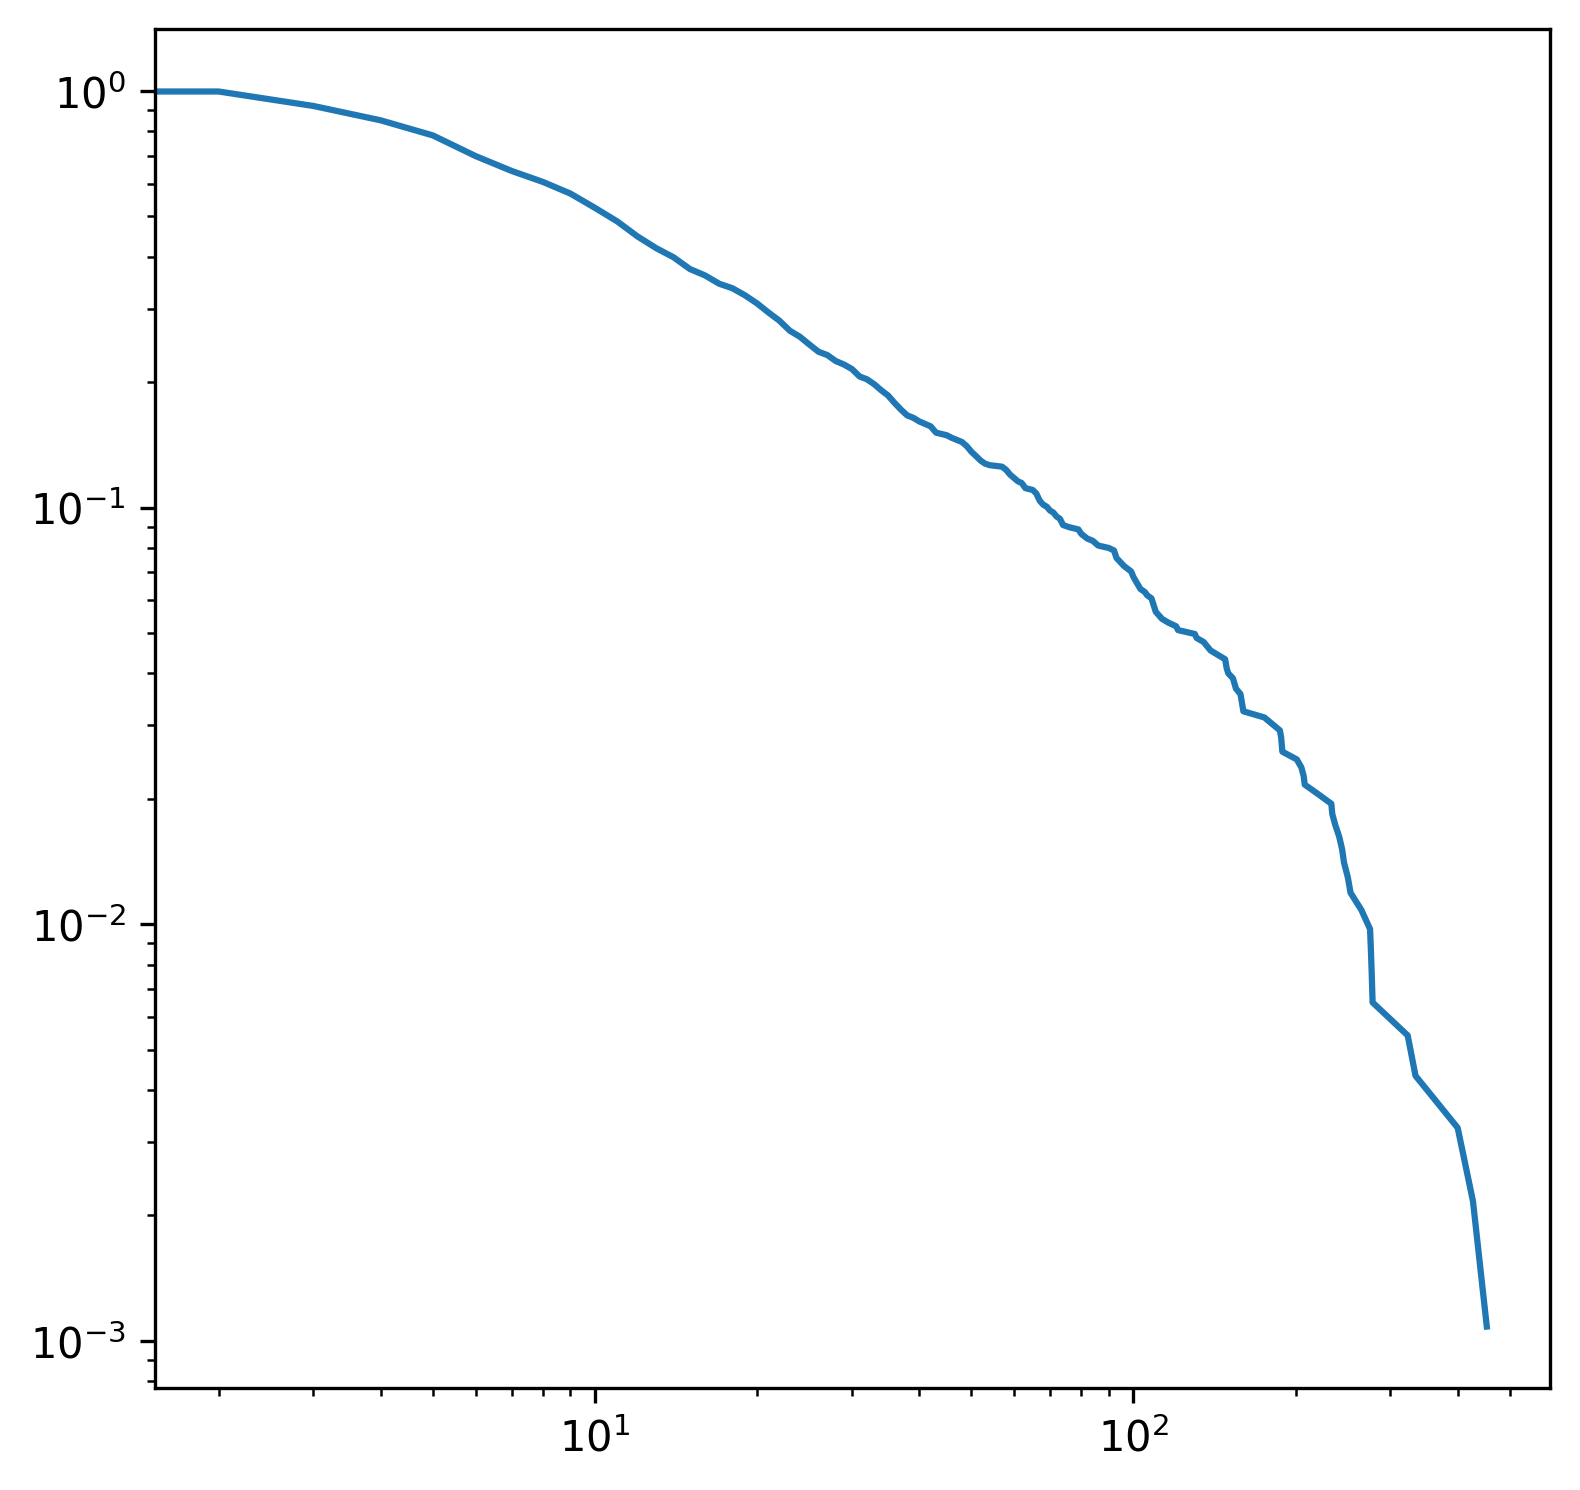

In [ ]:
#figure(figsize=(8, 8), dpi=80)


results = powerlaw.Fit(data=n_num_posts)
print(results.power_law.alpha)
print(results.power_law.xmin)
plt.figure(figsize=(6,6))
powerlaw.plot_ccdf(data=n_num_posts)